# DAML 10 - Perceptron

Michal Grochmal <michal.grochmal@city.ac.uk>

The perceptron is a quite old idea.
It was born as one of the alternatives for electronic gates
but computers with perceptron gates have never been built.
Instead, a perceptron is a very good model for online learning.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import f1_score

The percepton receives an arbitrary number of inputs,
multiplies each by a *weight*, sums them and then applies an *activation function*
to the result of this sum.  Given the number of inputs as the vector $x$, the
weights as the vector $w$, and the activation function as $a$;
For a single prediction all the perceptron does is:

$$\hat{y} = a \left( \sum w^T \cdot x \right)$$

Note that the vector $x$ has actually one extra input that is always of unit size.
This is called a bias term, and is similar to an amplifier in electronics.
Inputs to a perceptron should be normalized either between -1 and 1 or 0 and 1,
which may result in very small input sizes.  The perceptron may need to keep weights
small to account for a decision boundary in the small values, which may result with
very small outputs out of the perceptron.  The bias term can be then used to scale
the outputs out of the perceptron.

All we need to find is the correct vector $w$ of weights that gives the best classification.
There are two ways of doing it:

-   We can just use Gradient Descent (or other simple optimization) to find this vector.
-   We can perturb each weight by the size of it input and the error of the classification

The second option is much cheaper computationally,
therefore the most common perceptron learning rule is:

$$w_{i+1} = w_i + \eta(y - \hat{y})x_i$$

## Electronic Gates

We will attempt to learn boolean logic with our perceptron,
this was the original idea for the use of perceptrons
but they were implemented in hardware, not software.
The interesting part about this classification is that we can generate
the full set of data (not a sample) that will pass through our model,
therefore we can achieve 100% F1 score.

In [3]:
data = np.array([[0, 0],
                 [0, 1],
                 [1, 0],
                 [1, 1]])
y_or = data.any(axis=1).astype(np.int)
y_and = data.all(axis=1).astype(np.int)
y_nand = (~data.all(axis=1)).astype(np.int)
y_xor = (data[:, 0] != data[:, 1]).astype(np.int)
df_true = pd.DataFrame({'left': data[:, 0], 'rigth': data[:, 1],
                        'OR': y_or, 'AND': y_and, 'XOR': y_xor, 'NAND': y_nand},
                       columns=['left', 'rigth', 'OR', 'XOR', 'AND', 'NAND'])
df_true

,left,rigth,OR,XOR,AND,NAND
0,0,0,0,0,0,1
1,0,1,1,1,0,1
2,1,0,1,1,0,1
3,1,1,1,0,1,0


In [4]:
gates = {'or': y_or, 'and': y_and, 'xor': y_xor, 'nand': y_nand}
test = np.array([
    [0, 0], [0, 1], [1, 0], [1, 1],
    [1, 0], [0, 1], [1, 1], [0, 0],
    [1, 1], [1, 0], [0, 1], [0, 0],
])
test_y = {
    'or': test.any(axis=1).astype(np.int),
    'and': test.all(axis=1).astype(np.int),
    'xor': (test[:, 0] != test[:, 1]).astype(np.int),
    'nand': (~test.all(axis=1)).astype(np.int)
}
pcpt = Perceptron(max_iter=10)
for g in ['or', 'and', 'nand', 'xor']:
    pcpt.fit(data, gates[g])
    y_pred = pcpt.predict(test)
    f1 = f1_score(test_y[g], y_pred)
    print('###### Gate:', g.upper(), 'F1:', f1)

###### Gate: OR F1: 1.0
###### Gate: AND F1: 1.0
###### Gate: NAND F1: 1.0
###### Gate: XOR F1: 0.0


/home/grochmal/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Activation Function

We cannot learn XOR with a single perceptron, why is that?
The perceptron is a linear model and XOR is not a linear function.
The activation function of the perceptron that we are using is the `sign` function,
which is a linear function.

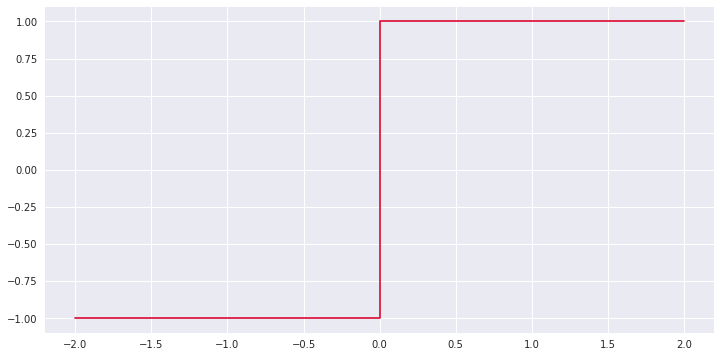

In [5]:
x1 = np.linspace(-2, 0, 10)
x2 = np.linspace(0, 2, 10)
y1 = x1*0 - 1
y2 = x2*0 + 1
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.hstack([x1, x2]), np.hstack([y1, y2]), color='crimson');

Yet we have more tricks in our sleeves, we can use more than one perceptron.
We know that:

$$\text{XOR}(a, b) = \text{AND}(\text{NAND}(a, b), \text{OR}(a, b))$$

Therefore we can build a XOR model with three perceptrons.

In [6]:
pcpt_or = Perceptron(max_iter=1e6)
pcpt_or.fit(data, y_or)
pcpt_nand = Perceptron(max_iter=1e6)
pcpt_nand.fit(data, y_nand)
pcpt_and = Perceptron(max_iter=1e6)
pcpt_and.fit(data, y_and)


def predict_xor(x):
    left = pcpt_or.predict(x)
    right = pcpt_nand.predict(x)
    return pcpt_and.predict(np.array(list(zip(left, right))))


y_pred = predict_xor(test)
f1_score(test_y['xor'], y_pred)

1.0

The three perceptrons together can be thought as a simple Neural Network.
The difference is that here we knew exactly how to train every perceptron separately,
which is not as easy in (possibly) complex neural networks.